# Analiza przeżycia na przykładzie zbioru colon z pakietu survival 
### Cel projektu:
Projekt ma na celu zaproponowanie prostego schematu analizy przeżycia, w którym badać będziemy efektywność adiuwantowych chemioterapii w leczeniu raka jelita grubego na podstawie zbioru danych *colon* z pakietu survival dedykowanego dla języka R. 
W ramach projektu zaproponowane zostaną modele:
1. Parametryczny
2. Nieparametryczny
3. Semiparametryczny
<br><br>
### Analiza przeżycia
Analiza przeżycia skupia się na modelowaniu czasu do zaistnienia jakiegoś zdarzenia, przykładowo takim zdarzeniem może być śmierć pacjenta lub nawrot choroby. Najczęsciej dane opierają się na badaniu prowadzonym przez jakiś określony czas na określonej próbie. Obserwację zdarzenia dla jednostki podczas okresu badania określamy jako failure, a brak obserwacji jako censoring. <br>
W analizie przeżycia chcemy określić wpływ zmiennych na prawdopodobieństwo zaistnienia danego zdarzenia. Przykładowo możemy chcieć sprawdzić, czy terapia jest efektywna w leczeniu choroby.
<br><br>
### Opis danych
Jak już zostało wspomniane do projektu użyliśmy zbioru danych *colon* z pakietu survival. Zbiór stworzony został na podstawie jednej z pierwszych udanych prób leczenia raka jelita grubego poprzez adiuwantową chemioterapię. 
 <br>
Cały zbiór składa się z 16 kolumn:
-  id: id
-  study: 1 for all patients
-  rx: Treatment - Obs(ervation), Lev(amisole), Lev(amisole)+5-FU
-  sex: 1=male
-  age: in years
-  obstruct: obstruction of colon by tumour
-  perfor: perforation of colon
-  adhere: adherence to nearby organs
-  nodes: number of lymph nodes with detectable cancer
-  time: days until event or censoring
-  status: censoring status
-  differ: differentiation of tumour (1=well, 2=moderate, 3=poor)
-  extent: Extent of local spread (1=submucosa, 2=muscle, 3=serosa, 4=contiguous structures)
-  surg: time from surgery to registration (0=short, 1=long)
-  node4: more than 4 positive lymph nodes
-  etype: event type: 1=recurrence,2=death

https://cran.r-project.org/web/packages/survival/survival.pdf

Aby nie komplikować zbytnio analizy, spośród wyżej wymieniobych wybraliśmy 6 zmiennych do naszej analizy, nie wliczając oczywistych zmiennych określających czas i status. Są to:
- rx
- sex
- age
- obstruct
- adhere
- differ
<br> <br> Zmienne te zostały wybrane arbitralnie kierując się naszą niewielką wiedzą na temat raka jelita grubego oraz dokumentacją pakietu survival, która wskazuje na istniejące problemy ze zmienną node4.

Analizę zaczynamy od załadowania potrzebnych bibliotek

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as lfl
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Ustawienie stylu wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

## Eksploracja danych

Analizę rozpoczynamy od krótkiej eksploracji naszego zbioru danych. Jak już zostało wspomniane, do analizy wybraliśmy zmienne: 'time', 'status', 'rx', 'sex', 'age', 'obstruct', 'adhere', 'differ'. 

Ponieważ chcemy badać wpływ terapi Lev(amisole) + 5-FU, wyrzucamy zmienną określającą terapię Lev(amisole), czyli 'rx' = 2

In [3]:
colon = pd.read_csv('../data/colon.csv')

In [4]:
colon = colon[['time', 'status', 'rx', 'sex', 'age', 'obstruct', 'adhere', 'differ']]

In [5]:
# Wyrzucamy Lev(amisole)
colon = colon[colon['rx'] != 2]

Na zbiór danych składa się 583 rekordów

In [6]:
len(colon)

583

In [7]:
colon.head()

,time,status,rx,sex,age,obstruct,adhere,differ
0,8,1,3,0,32,0,0,3
1,9,1,3,1,55,1,0,3
2,19,1,1,1,59,1,0,2
4,23,0,3,0,52,0,0,3
5,24,0,1,1,72,1,0,3


In [8]:
colon.loc[colon['time'] == colon['time'].max(), 'status']

887    0
Name: status, dtype: int64

## Analiza nieparametryczna

W analizie nieparametrycznej wyciągamy wnioski bezpośrednio z naszych danych bez przyjmowania żadnych dodatkowych założeń. Jej celem jest uzyskanie obserwowalnej krzywej przeżycia (survival curve) oraz obserwowalnej funkcji hazardu. Ponadto dla zmiennych kategorialnych możemy wizualnie sprawdzić wpływ zmiennej na krzywą przeżycia. 

Krzywą przeżycia wyznaczymy stosując estymator Kaplana-Meiera, natomiast funkcję hazardu wyznaczymy przy pomocy estymatora Nelsona-Aalena.

Kolejno przejdziemy przez następujące punkty:
- analiza korelacji zmiennych
- estymacja krzywej przeżycia
- estymacja funkcji hazardu
- wizualna ocena wpływu zmiennych na krzywą przeżycia oraz testy log-rank

### Analiza korelacji

In [9]:
# Tworzymy dataframe korelacji zmiennych
correlations = colon.corr()['time']
correlations_df = pd.DataFrame(correlations)
correlations_df.drop(['status', 'time'], inplace=True)
correlations_df.reset_index(inplace=True)
correlations_df.columns = ['zmienna', 'korelacja z czasem przeżycia']

<Axes: xlabel='korelacja z czasem przeżycia', ylabel='zmienna'>

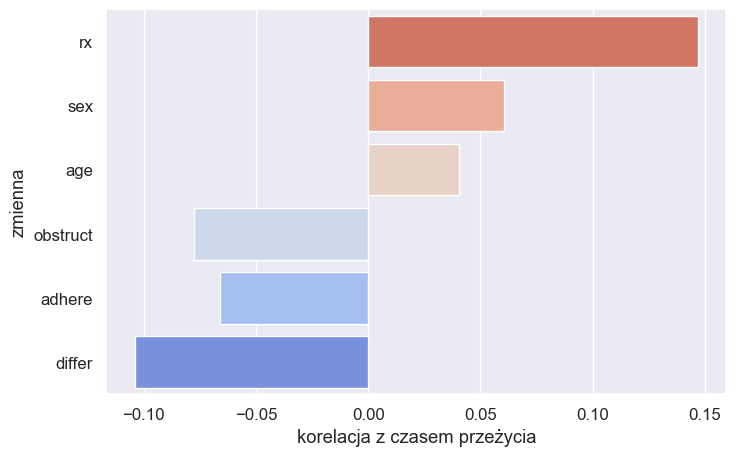

In [11]:
# Wizualizacja
plt.figure(figsize=(8, 5))
sns.barplot(
    data=correlations_df,    
    y='zmienna',
    x='korelacja z czasem przeżycia',
    palette='coolwarm_r', 
    orient='h'
)

Z powyższego wykresu wynika, że najsilniej skorelowaną z czasem przeżycia zmienną jest zmienna rx oznaczająca terapię. Zmienna ta jest pozytywnie skorelowana, co oznacza, że jej większa wartość idzie w parze z wydłużonym czasem przeżycia. Należy zatem zaznaczyć, że rx = 0 oznacza zwykłą obserwację pacjenta, natomiast rx = 3 oznacza terapię Lev(amisole) + 5-FU.

Obserwujemy również dosyć silną ujemną korelację zmiennej differ z czasem przeżycia. Zmienna differ określa poziom różnicy komórek rakowych ze zdrowymi komórkami, im wyższy poziom, tym gorzej.

### Krzywa przeżycia

Określa prawdopodobieństwo, że zmienna losowa $T$ (w naszym przypadku czas przeżycia pacjenta z rakiem jelita grubego) przekroczy $t$

In [12]:
T = colon['time']
E = colon['status']

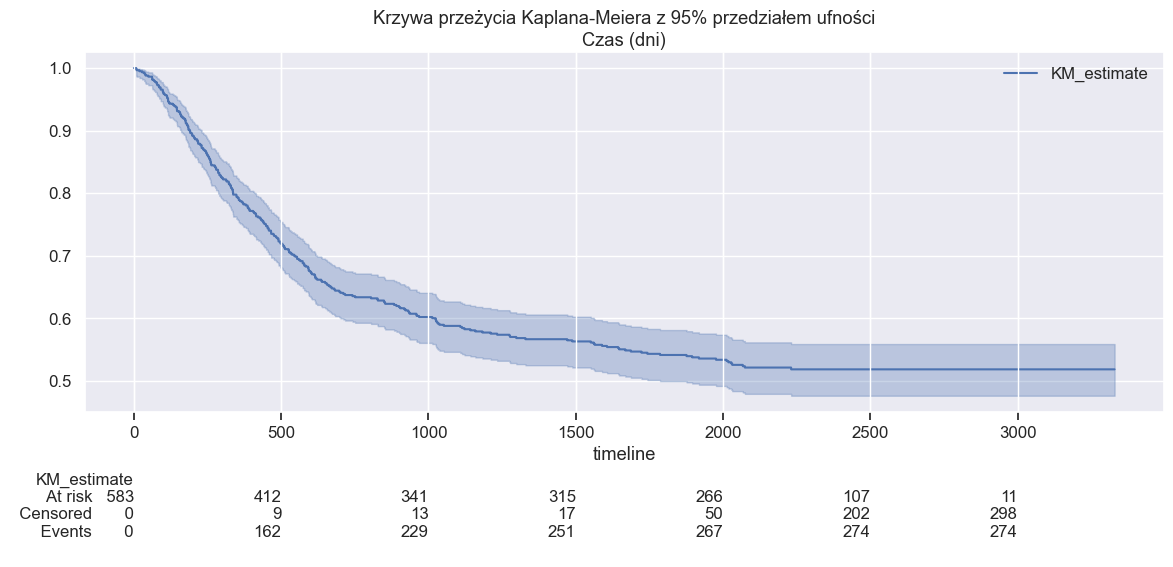

In [13]:
# Krzywa przeżycia - Kaplan-Meier
from lifelines.plotting import add_at_risk_counts

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf = lfl.KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, alpha=0.05)
kmf.plot(ax=ax, ci_show=True, ci_alpha=0.3)
add_at_risk_counts(kmf, ax=ax)

plt.title('Krzywa przeżycia Kaplana-Meiera z 95% przedziałem ufności')
plt.xlabel('Czas (dni)')
plt.ylabel('Prawdopodobieństwo przeżycia')
plt.grid(True)
plt.tight_layout()
plt.show()

Z powyższej krzywej przeżycia można wywnioskować, żę największe ryryko śmierci jest na samym początku. Prawdopodobnie są to najcięższe przypadki nowotworu jelita grubego. Później jednak krzywa się wygładza i tempo przyrostu obserwacji oznaczanych jako failure zdecydowanie maleje. Jest sporo ocenzurowanych pacjentów, czyli takich, dla których nie mamy informacji na temat wystąpienia zdarzenia (w naszym przypadku po prostu ocenzurowani pacjenci nie umarli w trakcie badania). Z krzywej wynika, że ponad połowa chorzych na raka jelita grubego przeżywa ponad 9 lat.

In [14]:
### Tabela przeżycia Kaplana-Meiera
print("\nTabela przeżycia Kaplana-Meiera")

### Tworzenie tabeli z wynikami
kmf_table = pd.DataFrame(kmf.survival_function_)
kmf_table.columns = ['Przeżycie']
kmf_table['Dolny przedz. ufności'] = kmf.confidence_interval_['KM_estimate_lower_0.95']
kmf_table['Górny przedz. ufności'] = kmf.confidence_interval_['KM_estimate_upper_0.95']
kmf_table['Skumulowana funkcja hazardu'] = -(np.log(kmf.survival_function_.values))
kmf_table['Skumulowana funkcja hazardu'][0] = 0 ### korekta wizualna
kmf_table['Zdarzenia'] = kmf.event_table['observed']
kmf_table['Cenzorowane'] = kmf.event_table['censored']
kmf_table['Narażeni na ryzyko'] = kmf.event_table['at_risk']


print("Fragment tabeli przeżycia (pierwsze 10 wierszy):")
display(kmf_table.head(10))
print("\nFragment tabeli przeżycia (ostatnie 10 wierszy):")
display(kmf_table.tail(10))


Tabela przeżycia Kaplana-Meiera
Fragment tabeli przeżycia (pierwsze 10 wierszy):


,Przeżycie,Dolny przedz. ufności,Górny przedz. ufności,Skumulowana funkcja hazardu,Zdarzenia,Cenzorowane,Narażeni na ryzyko
timeline,,,,,,,
0.0,1.000000,1.000000,1.000000,0.000000,0,0,583
8.0,0.998285,0.987887,0.999758,0.001717,1,0,583
9.0,0.996569,0.986354,0.999141,0.003436,1,0,582
19.0,0.994854,0.984131,0.998337,0.005159,1,0,581
23.0,0.994854,0.984131,0.998337,0.005159,0,1,580
24.0,0.994854,0.984131,0.998337,0.005159,0,1,579
28.0,0.993133,0.981808,0.997417,0.006891,1,0,578
35.0,0.991412,0.979491,0.996416,0.008625,1,0,577
38.0,0.989691,0.977197,0.995355,0.010363,1,0,576



Fragment tabeli przeżycia (ostatnie 10 wierszy):


,Przeżycie,Dolny przedz. ufności,Górny przedz. ufności,Skumulowana funkcja hazardu,Zdarzenia,Cenzorowane,Narażeni na ryzyko
timeline,,,,,,,
3024.0,0.518536,0.476379,0.558977,0.656746,0,1,10
3085.0,0.518536,0.476379,0.558977,0.656746,0,1,9
3087.0,0.518536,0.476379,0.558977,0.656746,0,1,8
3173.0,0.518536,0.476379,0.558977,0.656746,0,1,7
3185.0,0.518536,0.476379,0.558977,0.656746,0,1,6
3238.0,0.518536,0.476379,0.558977,0.656746,0,1,5
3308.0,0.518536,0.476379,0.558977,0.656746,0,1,4
3309.0,0.518536,0.476379,0.558977,0.656746,0,1,3
3325.0,0.518536,0.476379,0.558977,0.656746,0,1,2


### Funckja hazardu

In [15]:
## funkcja hazardu
naf = lfl.NelsonAalenFitter()
naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 583 total observations, 309 right-censored observations>

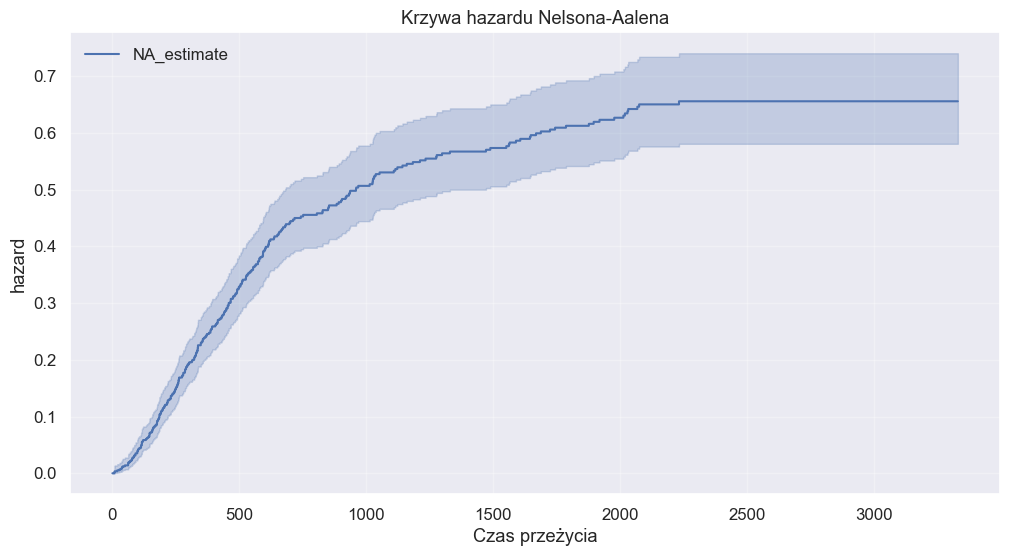

In [16]:
plt.figure(figsize=(12, 6))
naf.plot_cumulative_hazard()
plt.title('Krzywa hazardu Nelsona-Aalena')
plt.xlabel('Czas przeżycia')
plt.ylabel('hazard')
plt.grid(alpha = 0.3)
plt.show()

Skumulowane ryzyko śmierci zwiększa się z czasem, co jest całkowicie zasadne. Początkowo ten wzrost jest wysoki, co widzieliśmy również na krzywej przeżycia. Później tempo wzrostu ryzyka maleje.

### Zmienne

#### 1. Zmienna określająca sposób leczenia - *rx*

1 - obserwacja

3 - terapia lewamizolem +5-FU

In [17]:
colon['rx'].value_counts()

rx
1    294
3    289
Name: count, dtype: int64

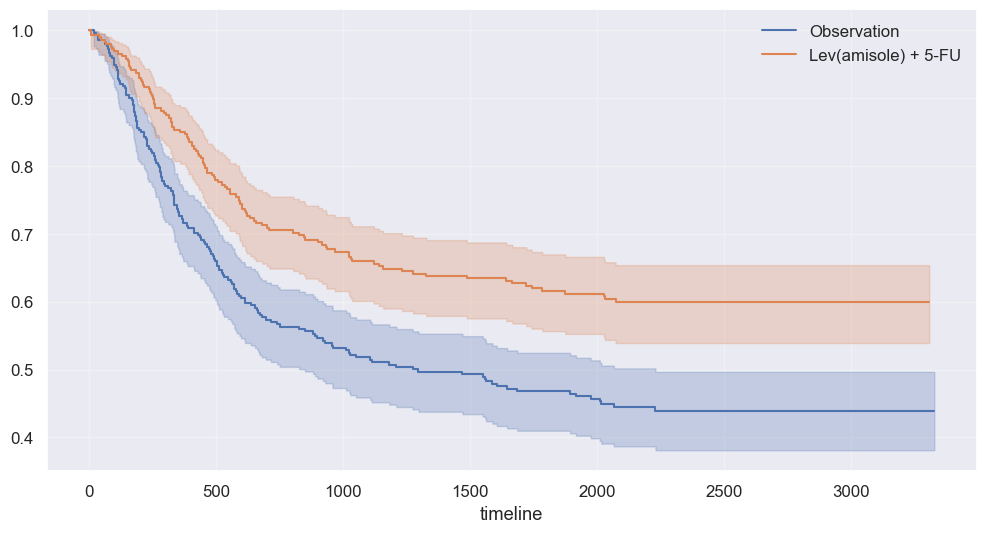

In [18]:
## K-M curve
rx1 = colon['rx'] == 1
rx3 = colon['rx'] == 3

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
kmf.fit(durations=T[rx1], event_observed=E[rx1], label='Observation', alpha=0.05)
kmf.plot(ax=ax)
kmf.fit(durations=T[rx3], event_observed=E[rx3], label='Lev(amisole) + 5-FU', alpha=0.05)
kmf.plot(ax=ax)
plt.grid(alpha = 0.3)

Krzywe narysowane z 95% przedziałem ufności. Krzywa dla pacjentów, którzy leczeni są terapią Lev(amisole) + 5-FU jest istotnie powyżej krzywej dla pacjentów tylko obserwowanych. Możemy wnioskować, że terapia zwiększa czas przeżycia.

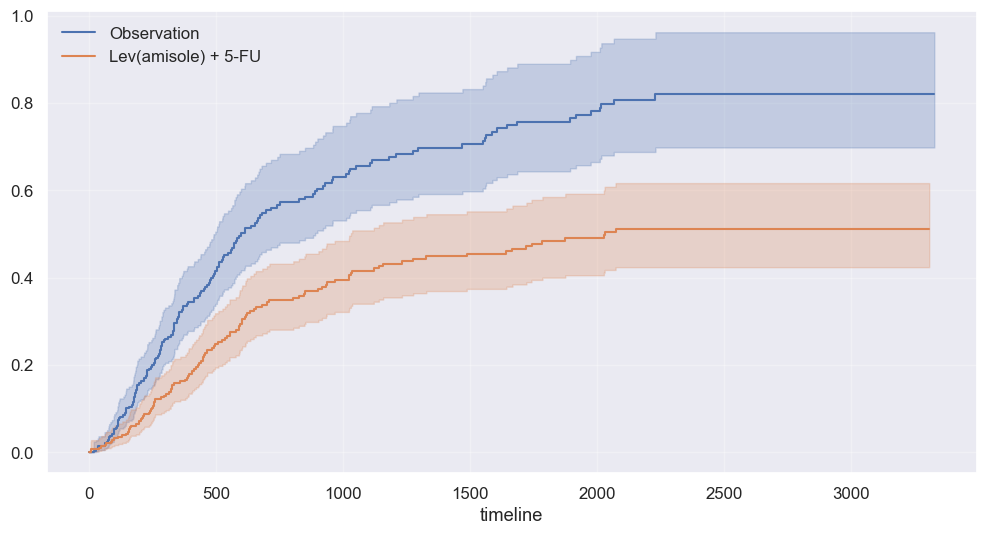

In [19]:
plt.figure(figsize=(12, 6))

ax = plt.subplot(111)

naf.fit(durations=T[rx1], event_observed=E[rx1], label='Observation', alpha=0.05)
naf.plot(ax=ax)


naf.fit(durations=T[rx3], event_observed=E[rx3], label='Lev(amisole) + 5-FU', alpha=0.05)
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [20]:
## Log-Rank test

result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['rx'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          15.77 <0.005     13.77

Wyniki testu log-rank pozwalają nam odrzucić hipotezę zerową zakładającą brak różnicy rozkładów czasu przeżycia dla badanych kategorii. Możemy podejrzeważ, że zmienna rx okaże się istotna w modelach parametrycznych i semiparametrycznych.

#### 2. Zmienna określająca płeć - *sex*

0 - mężczyzna

1 - kobieta

In [21]:
colon['sex'].value_counts()

sex
1    299
0    284
Name: count, dtype: int64

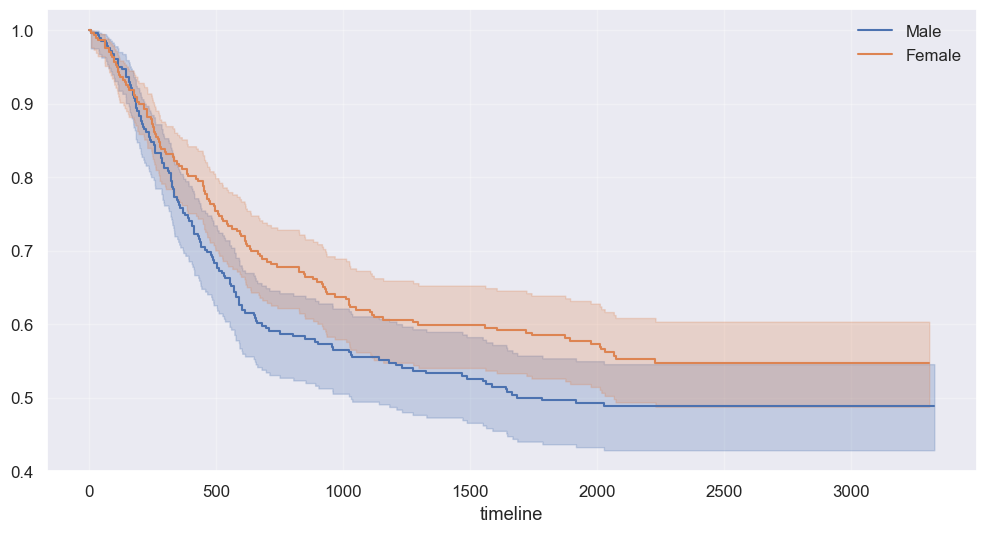

In [22]:
## Krzywa K-M
m = colon['sex'] == 0

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[m], event_observed=E[m], label='Male', alpha=0.05)
kmf.plot(ax=ax)

kmf.fit(durations=T[~m], event_observed=E[~m], label='Female', alpha=0.05)
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

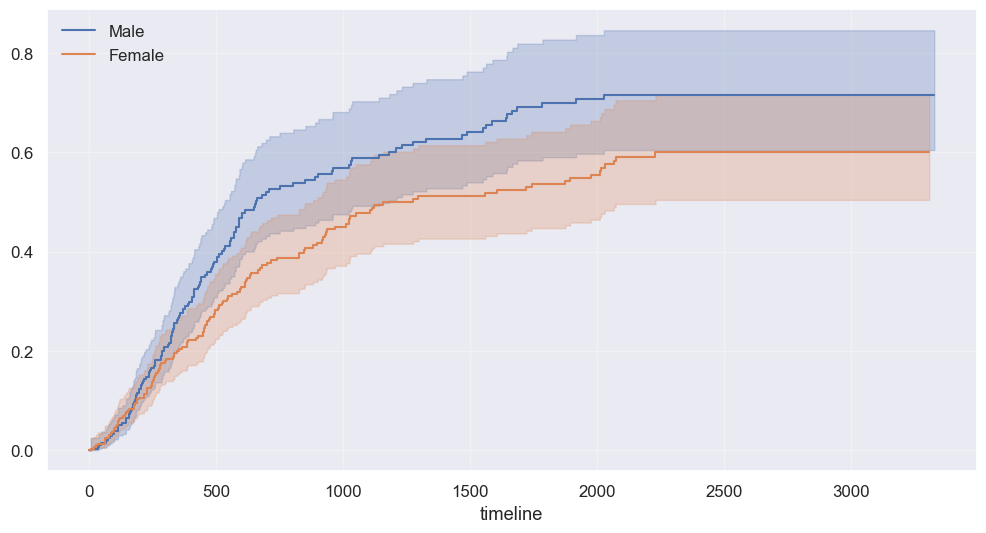

In [23]:
## Funkcja hazardu

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

naf.fit(durations=T[m], event_observed=E[m], label='Male', alpha=0.05)
naf.plot(ax=ax)

naf.fit(durations=T[~m], event_observed=E[~m], label='Female', alpha=0.05)
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [22]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['sex'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           2.97 0.08      3.56

Przy poziomie istotności 5% nie możemy odrzucić hipotezy zerowej.

#### 3. Zmienna obstruct

Określa, czy guz blokuje drożność jelita. Jeśli tak, to zmienna przyjmuje wartość 1, przeciwnie 0

In [23]:
colon['obstruct'].value_counts()

obstruct
0    474
1    109
Name: count, dtype: int64

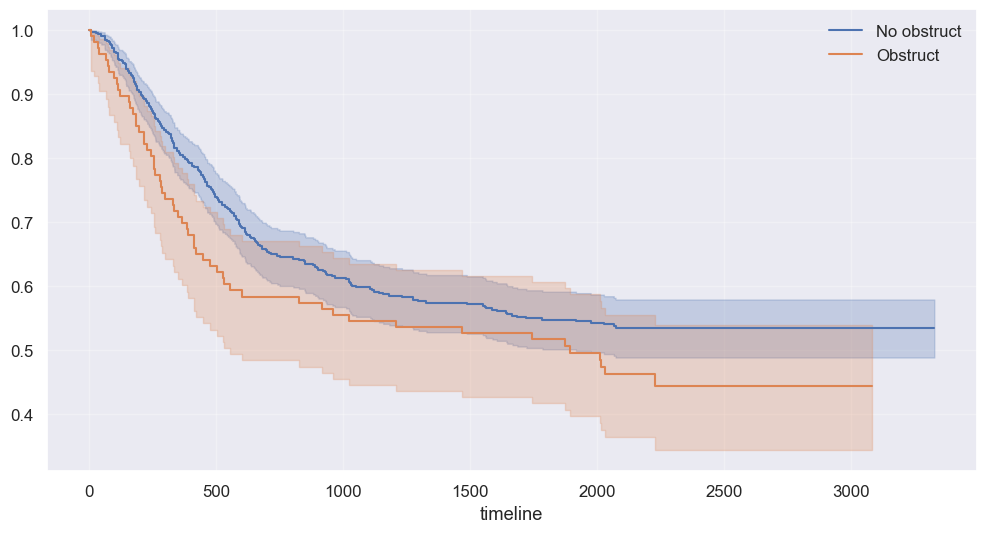

In [32]:
## Krzywa K-M
o = colon['obstruct'] == 0

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[o], event_observed=E[o], label='No obstruct', alpha=0.05)
kmf.plot(ax=ax)

kmf.fit(durations=T[~o], event_observed=E[~o], label='Obstruct', alpha = 0.05)
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

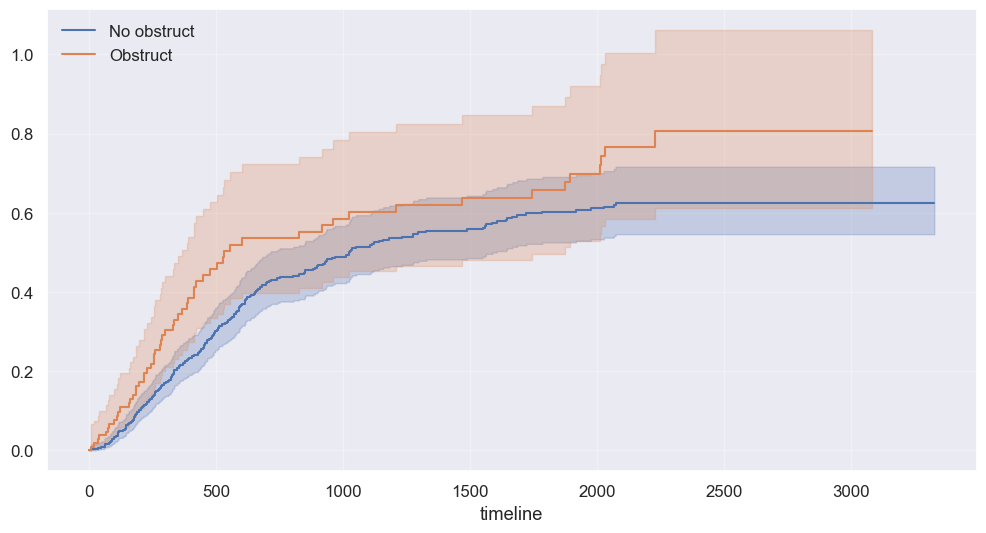

In [33]:
## Funkcja hazardu

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

naf.fit(durations=T[o], event_observed=E[o], label='No obstruct', alpha=0.05)
naf.plot(ax=ax)

naf.fit(durations=T[~o], event_observed=E[~o], label='Obstruct', alpha=0.05)
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [34]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['obstruct'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.13 0.08      3.70

Podobnie jak w przypadku płci, nie ma podstaw do odrzucenia hipotezy zerowej zakładającej identyczność krzywych przeżycia dla wszystkich kategorii, przy poziomie istotności 95%. Interesujące jest przycięcie dla kategorii No obstruct na wykresach wskazujące na to, że ostatni pacjent z tej kategorii został ocenzurowany wcześniej niż ostatni pacjent z kategorii Obstruct. Nie mamy szczegółowych informacji na temat oryginalnego badania, więc możemy jedynie snuć domysły na temat przyczyny takiego stanu rzeczy.

#### 4. Zmienna adhere

In [35]:
colon['adhere'].value_counts()

adhere
0    500
1     83
Name: count, dtype: int64

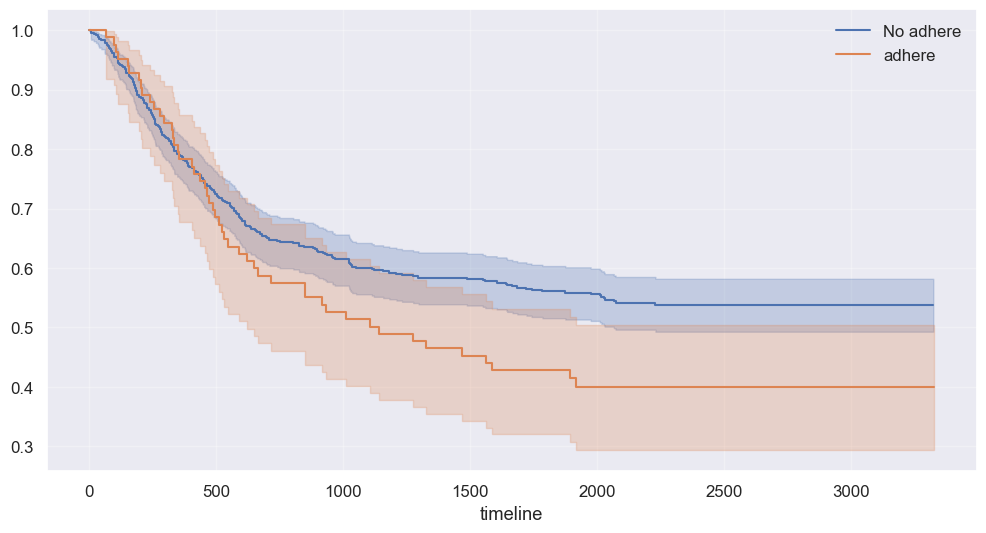

In [36]:
## Krzywa K-M
a = colon['adhere'] == 0

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[a], event_observed=E[a], label='No adhere', alpha = 0.05)
kmf.plot(ax=ax)

kmf.fit(durations=T[~a], event_observed=E[~a], label='adhere', alpha = 0.05)
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

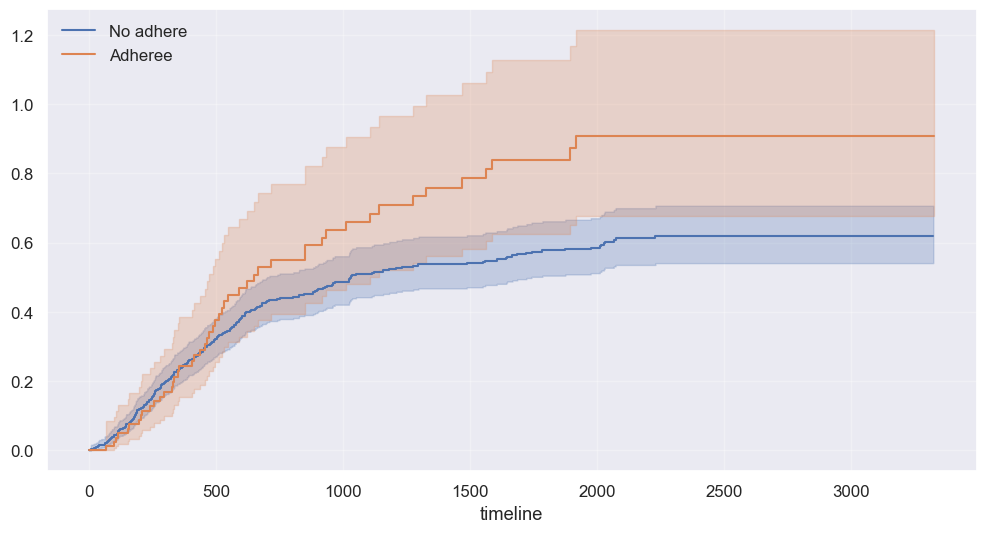

In [37]:
## Funkcja hazardu

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

naf.fit(durations=T[a], event_observed=E[a], label='No adhere', alpha = 0.05)
naf.plot(ax=ax)

naf.fit(durations=T[~a], event_observed=E[~a], label='Adheree', alpha = 0.05)
naf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [38]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['adhere'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           4.10 0.04      4.54

Odrzucenie hipotezy zerowej zakładającej identyczność krzywych przeżycia dla wszystkich kategorii, przy poziomie istotności 95%. Patrząc na wykres jest to dosyć interesujący wynik testu Log-Rank. Widoczny jest niewielki interwał na którym przedziały ufności się nie pokrywają. Krzywa przeżycia dla kategorii *adhere* leży wyraźnie niżej, ale ma ona również zdecydowanie szerszy przedział ufności. Oznacza to, że jesteśmy bardziej pewni kształtu krzywej przeżycia dla pacjentów z guzem nieadherentnym. 


#### 5. Zmienna differ



In [39]:
colon['differ'].value_counts()

differ
2    427
3     93
1     63
Name: count, dtype: int64

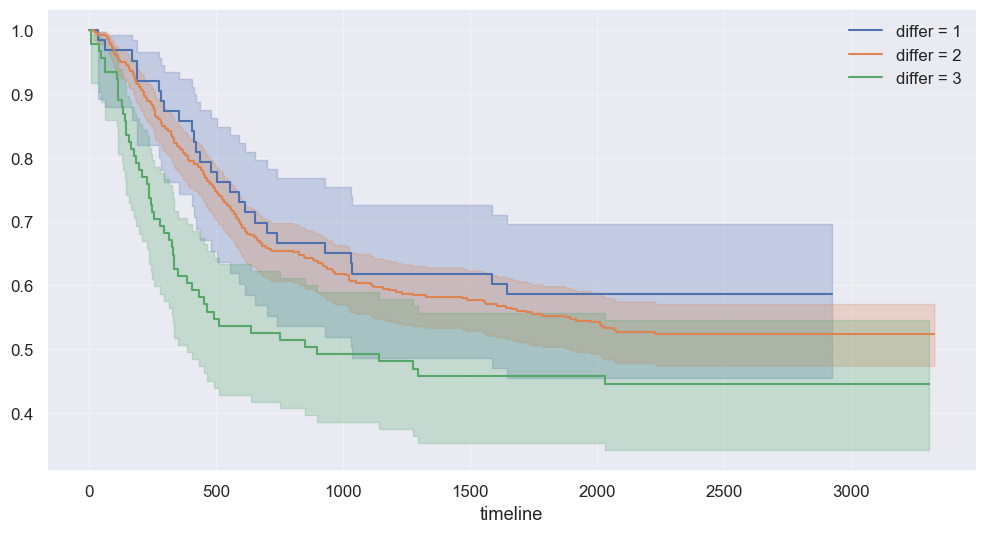

In [40]:
## Krzywa K-M
d1 = colon['differ'] == 1
d2 = colon['differ'] == 2
d3 = colon['differ'] == 3

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

kmf.fit(durations=T[d1], event_observed=E[d1], label='differ = 1')
kmf.plot(ax=ax)

kmf.fit(durations=T[d2], event_observed=E[d2], label='differ = 2')
kmf.plot(ax=ax)

kmf.fit(durations=T[d3], event_observed=E[d3], label='differ = 3')
kmf.plot(ax=ax)

plt.grid(alpha = 0.3)

In [41]:
## Log-Rank test
result = lfl.statistics.multivariate_logrank_test(colon['time'], colon['adhere'], colon['status'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           4.10 0.04      4.54

Odrzucenie hipotezy zerowej zakładającej identyczność krzywych przeżycia dla wszystkich kategorii, przy poziomie istotności 95%. Dosyć wyraźnie widać to również na wykresie. Sam wykres poniekąd potwierdza nasze wcześniejsze przypuszczenia (przynajmniej wizualnie), że początkowe wysokie nachylenie krzywej przeżycia jest wynikiem sporej ilości śmierci pacjentów z nowotworami bardziej agresywnymi. Tutaj te nowotwory pośrednio określa zmienna differ = 3. Dokładnie oznacza ona najsłabsze zróżnicowanie komórek rakowych w rozumieniu takim, że nie są one podobne do zdrowych komórek. To najczęściej charakteryzuje bardziej agresywne nowotwory.

## Analiza parametryczna

Analiza parametryczna w analizie przeżycia polega na założeniu określonego rozkładu prawdopodobieństwa czasu przeżycia, takiego jak rozkład wykładniczy, Weibulla, log-normalny czy gamma. W przeciwieństwie do metod nieparametrycznych, analiza parametryczna umożliwia także prognozowanie przeżycia poza obserwowanym zakresem danych. Jednak ważnym ograniczeniem tych metod jest konieczność poprawnego doboru rozkładu, gdyż błędne założenia mogą prowadzić do niewiarygodnych wyników.

W naszej analizie uwzględniamy 3 rozkłady:
- rozkład Weibulla
- rozkład log-normalny
- rozkład log-logistyczny

Wszystkie zastosowane przez nas modele są modelami AFT

Zanim jednak przejdziemy do analizy parametrycznej należy odpowiednio przygotować dane. Mamy zmienne, które mają więcej niż 2 kategorie. Te zmienne muszą zostać przedefiniowane jako zmienne zero-jedynkowe

In [59]:
colon = pd.get_dummies(colon, columns = ['differ'], drop_first=True)
colon.head()

,time,status,rx,sex,age,obstruct,adhere,differ_2,differ_3
0,8,1,3,0,32,0,0,False,True
1,9,1,3,1,55,1,0,False,True
2,19,1,1,1,59,1,0,True,False
4,23,0,3,0,52,0,0,False,True
5,24,0,1,1,72,1,0,False,True


### 1. Wybór modelu

In [60]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

wb_aft, ln_aft, ll_aft = WeibullAFTFitter(), LogNormalAFTFitter(), LogLogisticAFTFitter()
wb_aft.fit(colon, duration_col = 'time', event_col = 'status')
ln_aft.fit(colon, duration_col = 'time', event_col = 'status')
ll_aft.fit(colon, duration_col = 'time', event_col = 'status')


<lifelines.LogLogisticAFTFitter: fitted with 583 total observations, 309 right-censored observations>

### Porównanie modeli

Porównanie prognozowanych krzywych przeżycia dla pierwszej obserwacji, czyli tej, dla tej z najwcześniejszym failure

In [61]:
colon.iloc[0:1]

,time,status,rx,sex,age,obstruct,adhere,differ_2,differ_3
0,8,1,3,0,32,0,0,False,True


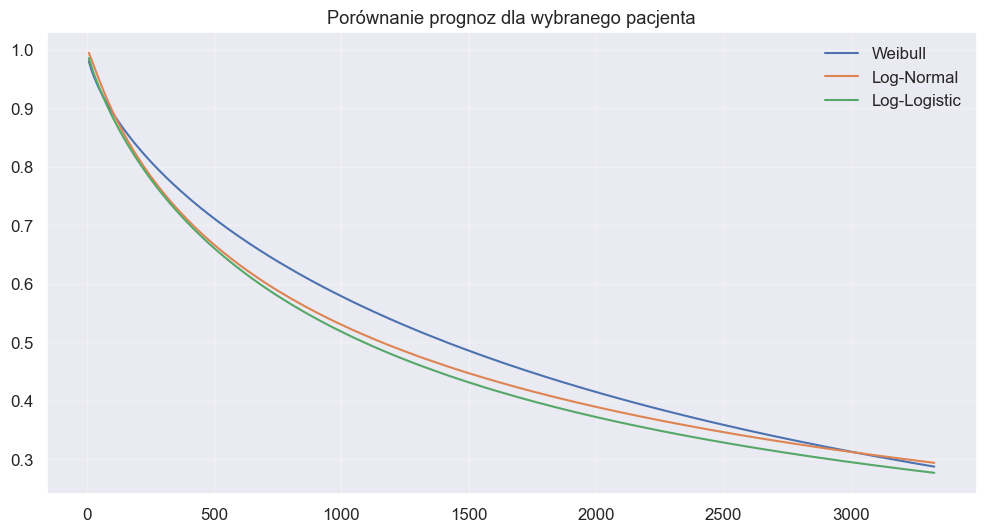

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(wb_aft.predict_survival_function(colon.iloc[0:1]), label = 'Weibull')
plt.plot(ln_aft.predict_survival_function(colon.iloc[0:1]), label = 'Log-Normal')
plt.plot(ll_aft.predict_survival_function(colon.iloc[0:1]), label = 'Log-Logistic')
plt.grid(alpha = 0.3)
plt.title('Porównanie prognoz dla wybranego pacjenta')
plt.legend()
plt.show()

Estymowane wykresy pokazują, że pacjent względem całej populacji nie rokował dobrze. Jest to spodziewane, jako, że był to pacjent z najwcześniejszym failure.

Porównanie wartości funkcji największej wiarygodności

In [63]:
print(f"Weibull LL: {wb_aft.log_likelihood_}")
print(f"Log-Normal LL: {ln_aft.log_likelihood_}")
print(f"Log-Logistic LL: {ll_aft.log_likelihood_}")

Weibull LL: -2430.981014547335
Log-Normal LL: -2404.2565668424786
Log-Logistic LL: -2414.626098121339


In [64]:
models = {
    'Weibull': wb_aft,
    'LogNormal': ln_aft,
    'LogLogistic': ll_aft
}

#obliczamy AIC modeli
aic_values = {}
c_values = {}
for name, model in models.items():
    aic_values[name] = model.AIC_
    c_values[name] = model.concordance_index_

for name, model in models.items():
    print(f"\n{name} Podsumowanko:")
    print(f"AIC: {model.AIC_}")
    print(f"Concordance_index: {model.concordance_index_}")

#najlepszy model
best_model_name = min(aic_values, key=aic_values.get)
best_model = models[best_model_name]
print(f"\nNajlepszy model na podstawie AIC: {best_model_name} (AIC={aic_values[best_model_name]})")
best_model_name = max(c_values, key=c_values.get)
best_model = models[best_model_name]
print(f"\nNajlepszy model na podstawie Concordance index: {best_model_name} (Concordance index={c_values[best_model_name]})")



Weibull Podsumowanko:
AIC: 4879.96202909467
Concordance_index: 0.6087186062297307

LogNormal Podsumowanko:
AIC: 4826.513133684957
Concordance_index: 0.6106334481400474

LogLogistic Podsumowanko:
AIC: 4847.252196242678
Concordance_index: 0.6104826072018168

Najlepszy model na podstawie AIC: LogNormal (AIC=4826.513133684957)

Najlepszy model na podstawie Concordance index: LogNormal (Concordance index=0.6106334481400474)


In [65]:
c_values

{'Weibull': np.float64(0.6087186062297307),
 'LogNormal': np.float64(0.6106334481400474),
 'LogLogistic': np.float64(0.6104826072018168)}

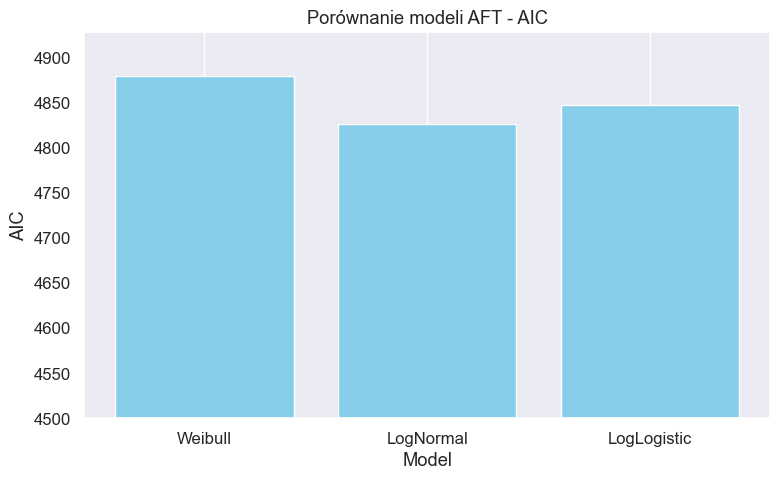

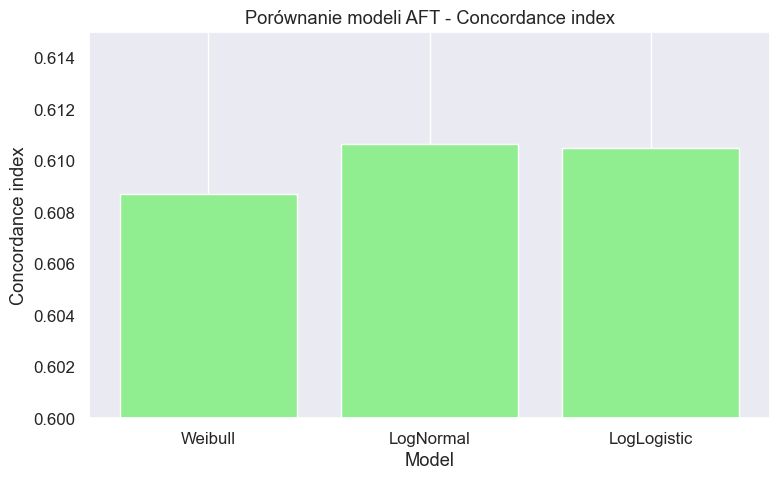

In [66]:
models = {
    'Weibull': 'Weibull',
    'LogNormal': 'LogNormal',
    'LogLogistic': 'LogLogistic'
}
aicdf=pd.DataFrame({
    "Model": models,
    "AIC": aic_values,
})
cdf=pd.DataFrame({
    "Model": models,
    "Concordance index": c_values,
})
# Wykres AIC
plt.figure(figsize=(8, 5))
plt.bar(aicdf['Model'], aicdf['AIC'], color='skyblue')
plt.title('Porównanie modeli AFT - AIC')
plt.ylabel('AIC')
plt.xlabel('Model')
plt.grid(axis='y')
plt.ylim(4500, max(aicdf['AIC']) * 1.01)  
plt.tight_layout()
plt.show()

# Wykres Concordance Index
plt.figure(figsize=(8, 5))
plt.bar(cdf['Model'], cdf['Concordance index'], color='lightgreen')
plt.title('Porównanie modeli AFT - Concordance index')
plt.ylabel('Concordance index')
plt.xlabel('Model')
plt.grid(axis='y')
plt.ylim(0.6, 0.6150)  
plt.tight_layout()
plt.show()

Najlepszy model to model z rozkładem lognormalnym - najwyższy log likelihhod, najniższy AIC oraz najwyższy concordance. Przyjżymy się teraz nieco dokładniej temu modelowi.

In [67]:
ln_aft = LogNormalAFTFitter()
ln_aft.fit(colon, duration_col='time', event_col='status')
ln_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 583
number of events observed = 274
           log-likelihood = -2404.26
         time fit was run = 2025-06-08 09:58:00 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    adhere    -0.30      0.74      0.25           -0.80            0.19                0.45                1.21
       age        0.01      1.01      0.01           -0.00            0.03                1.00                1.03
       differ_2  -0.32      0.73      0.30           -0.91            0.28                0.40                1.32
       differ_3  -1.07      0.34      0.36           -1.77           -0.36                0.17                0.70
       obstruct  -0.40      0.67      0.23           -0.85            0.05                0.43                1.06
       rx         0.40      1.49      0.09            0.22            0.58                1.24                1.79
       sex        0.40      1.49      0.18            0.04            0.76                1.04                2.14
       Intercept  6.54    694.92      0.57            5.42            7.66              226.69             2130.28
sigma_ Intercept  0.67      1.95      0.05            0.57            0.76                1.77                2.14

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    adhere       0.00 -1.20   0.23      2.13
       age          0.00  1.56   0.12      3.08
       differ_2     0.00 -1.05   0.29      1.76
       differ_3     0.00 -2.95 <0.005      8.30
       obstruct     0.00 -1.72   0.08      3.56
       rx           0.00  4.29 <0.005     15.78
       sex          0.00  2.18   0.03      5.08
       Intercept    0.00 11.45 <0.005     98.41
sigma_ Intercept    0.00 13.83 <0.005    142.04
---
Concordance = 0.61
AIC = 4826.51
log-likelihood ratio test = 39.04 on 7 df
-log2(p) of ll-ratio test = 18.99

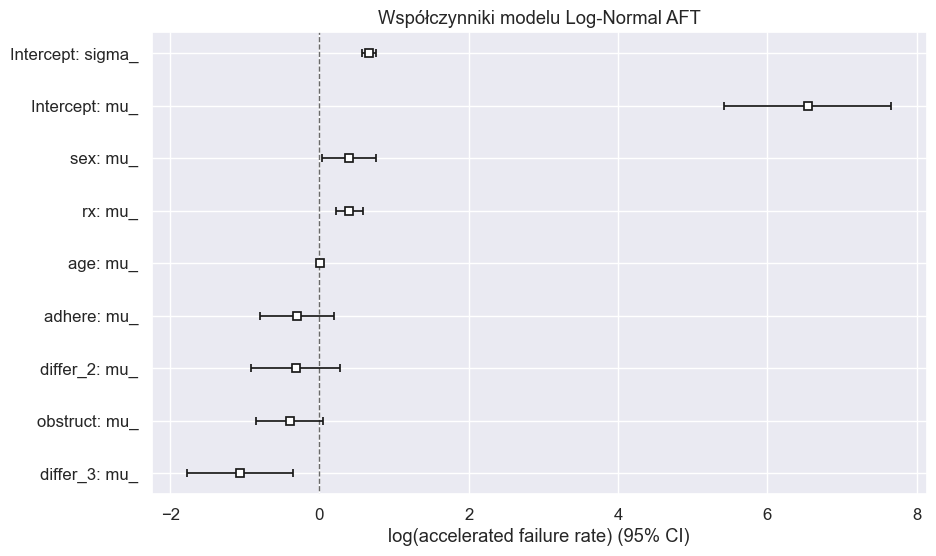

In [68]:
#wykres log(accelerated failure)
fig, ax = plt.subplots(figsize=(10, 6))
ln_aft.plot(ax=ax)
plt.title("Współczynniki modelu Log-Normal AFT")
plt.grid(True)
plt.show()

statystycznie istotne zmienne: differ, rx, age_category_mid, age_catefory_old, differ_3, sex. Ale zostawiamy również zmienną obstruct

In [69]:
ln_aft = LogNormalAFTFitter()
ln_aft.fit(colon[['time', 'status', 'differ_3', 'rx', 'sex', 'obstruct']], duration_col='time', event_col='status')
ln_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 583
number of events observed = 274
           log-likelihood = -2406.66
         time fit was run = 2025-06-08 09:58:01 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    differ_3  -0.83      0.44      0.24           -1.30           -0.35                0.27                0.70
       obstruct  -0.43      0.65      0.23           -0.88            0.02                0.41                1.02
       rx         0.39      1.48      0.09            0.21            0.58                1.24                1.78
       sex        0.40      1.49      0.18            0.04            0.76                1.04                2.13
       Intercept  6.96   1050.22      0.24            6.50            7.42              662.44             1664.98
sigma_ Intercept  0.67      1.95      0.05            0.57            0.76                1.78                2.15

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    differ_3     0.00 -3.40 <0.005     10.54
       obstruct     0.00 -1.88   0.06      4.06
       rx           0.00  4.26 <0.005     15.56
       sex          0.00  2.17   0.03      5.07
       Intercept    0.00 29.59 <0.005    636.75
sigma_ Intercept    0.00 13.87 <0.005    142.96
---
Concordance = 0.60
AIC = 4825.31
log-likelihood ratio test = 34.24 on 4 df
-log2(p) of ll-ratio test = 20.52

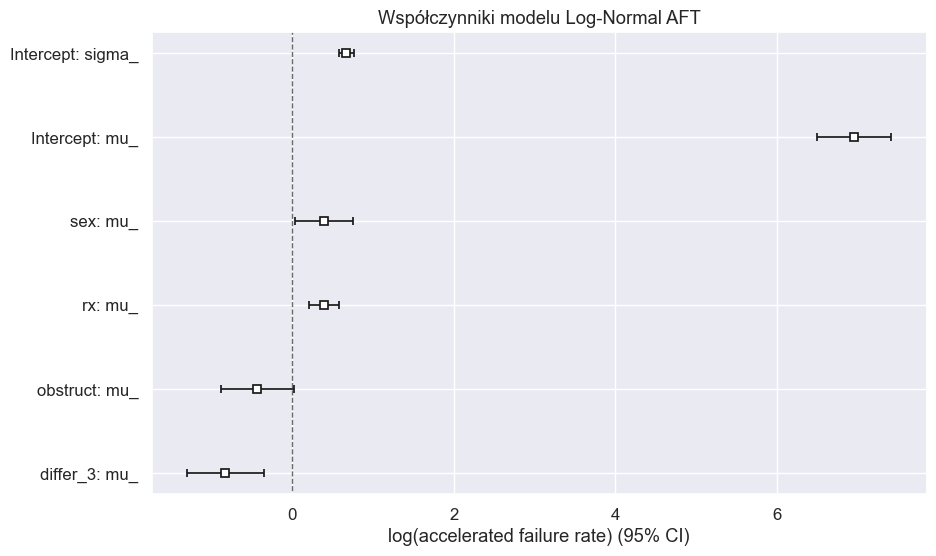

In [70]:
#wykres log(accelerated failure)
fig, ax = plt.subplots(figsize=(10, 6))
ln_aft.plot(ax=ax)
plt.title("Współczynniki modelu Log-Normal AFT")
plt.grid(True)
plt.show()

In [71]:
#mediana i średnia
print(f"Mediana: {ln_aft.median_survival_time_}")
print(f"Średnia: {ln_aft.mean_survival_time_}")

Mediana: 2319.445426845548
Średnia: 15614.693210610367


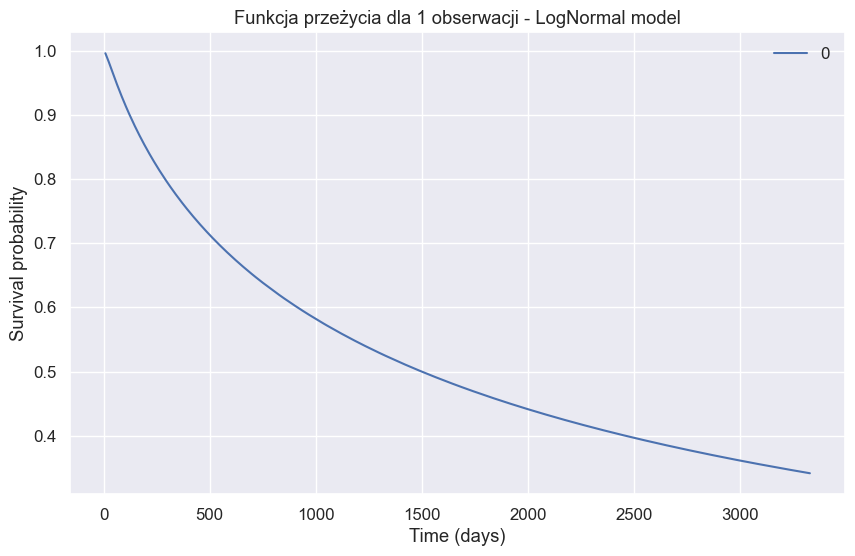

In [72]:
#funkcja przeżycia dla 1 obserwacji
surv_func = ln_aft.predict_survival_function(colon.iloc[0:1])
fig, ax = plt.subplots(figsize=(10, 6))
surv_func.plot(ax=ax, title="Funkcja przeżycia dla 1 obserwacji - LogNormal model")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
ax.grid(True)
plt.show()

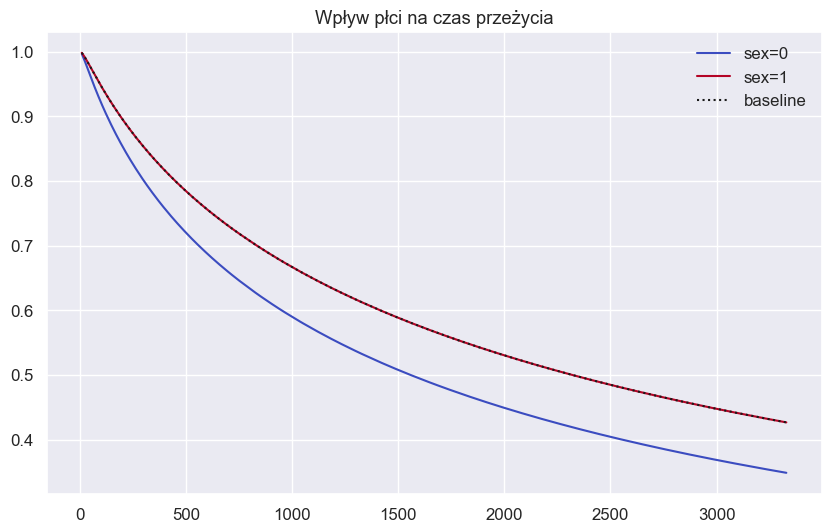

In [73]:
#wykresy partial effects on outcome
fig, ax = plt.subplots(figsize=(10, 6))
ln_aft.plot_partial_effects_on_outcome('sex', (0, 1), cmap='coolwarm', ax=ax)
ax.set_title('Wpływ płci na czas przeżycia')
plt.show()

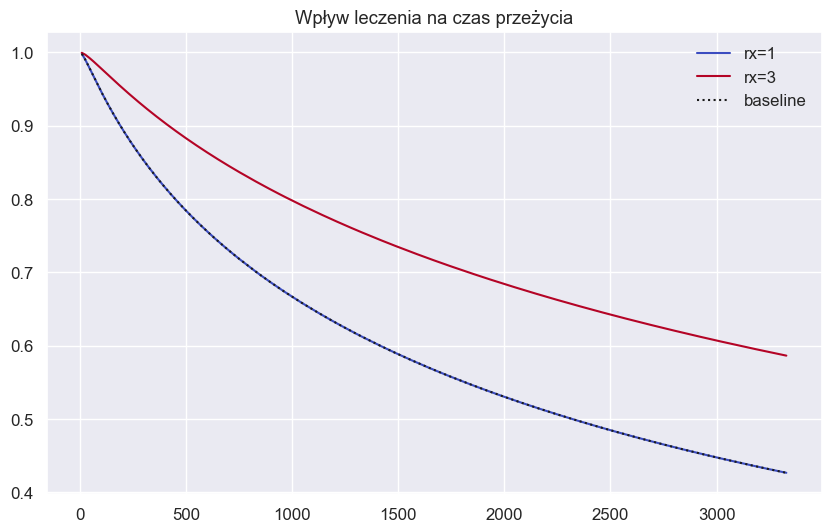

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))
ln_aft.plot_partial_effects_on_outcome('rx', (1,3), cmap='coolwarm', ax=ax)
ax.set_title('Wpływ leczenia na czas przeżycia')
plt.show()

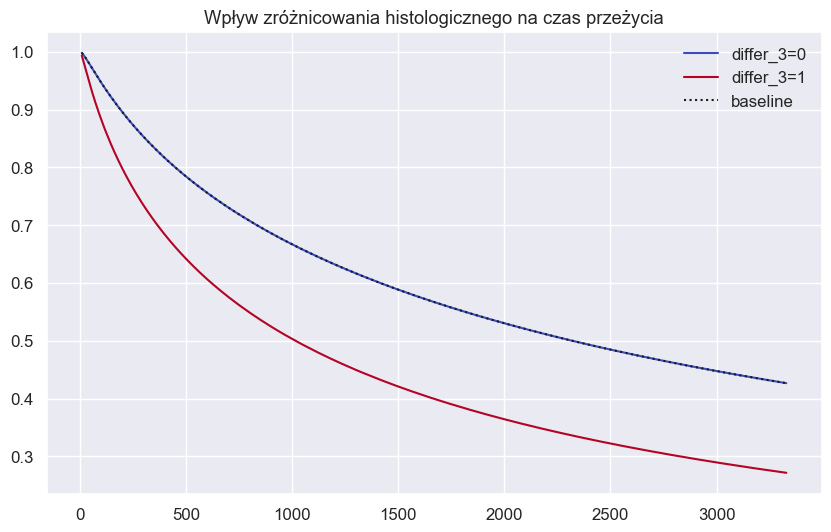

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
ln_aft.plot_partial_effects_on_outcome('differ_3',(0,1), cmap='coolwarm', ax=ax)
ax.set_title('Wpływ zróżnicowania histologicznego na czas przeżycia')
plt.show()

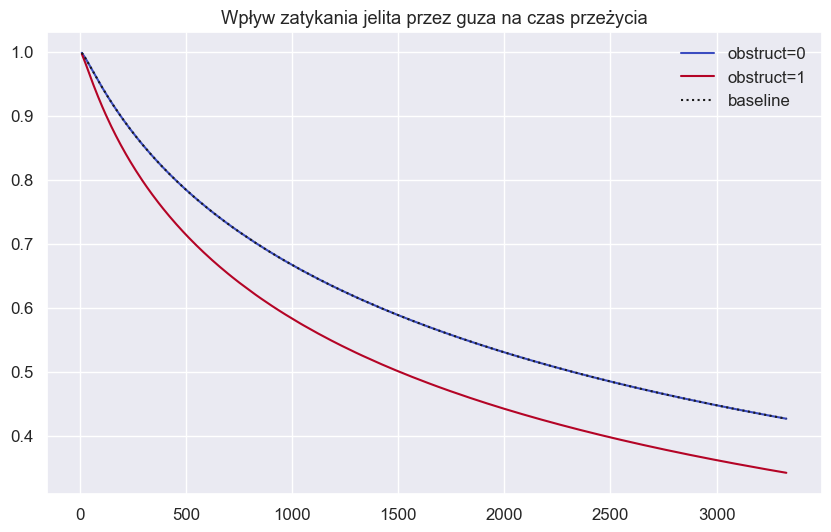

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
ln_aft.plot_partial_effects_on_outcome('obstruct',(0,1), cmap='coolwarm', ax=ax)
ax.set_title('Wpływ zatykania jelita przez guza na czas przeżycia')
plt.show()

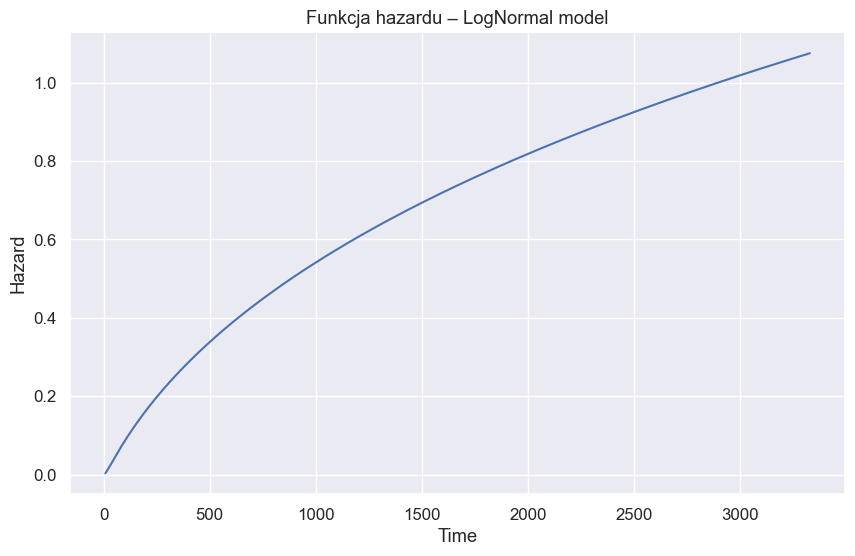

In [77]:
# Funkcja hazardu 
plt.figure(figsize=(10, 6))
plt.plot(ln_aft.predict_cumulative_hazard(colon.iloc[0:1]))
plt.title('Funkcja hazardu – LogNormal model')
plt.xlabel('Time')
plt.ylabel('Hazard')
plt.grid(True)
plt.legend()
plt.show()

In [78]:
# Po dopasowaniu modelu AFT, uzyskujemy macierz kowariancji:
cov_matrix = ln_aft.variance_matrix_

# Konwersja macierzy kowariancji do DataFrame (czytelniejszy format)
cov_matrix_df = pd.DataFrame(cov_matrix)

In [79]:
# Macierz kowariancji współczynników (jak COVB w SAS)
print("\nMacierz kowariancji (COVB):")
print(cov_matrix_df)


Macierz kowariancji (COVB):
param                  mu_                                            sigma_
covariate         differ_3  obstruct        rx       sex Intercept Intercept
param  covariate                                                            
mu_    differ_3   0.059036  0.000696 -0.001622 -0.002435 -0.006525 -0.000690
       obstruct   0.000696  0.052928  0.000652  0.000775 -0.012394 -0.000381
       rx        -0.001622  0.000652  0.008562  0.002069 -0.016822  0.000539
       sex       -0.002435  0.000775  0.002069  0.033614 -0.019858  0.000561
       Intercept -0.006525 -0.012394 -0.016822 -0.019858  0.055279  0.001239
sigma_ Intercept -0.000690 -0.000381  0.000539  0.000561  0.001239  0.002328


## Analiza semiparametryczna - model parametrycznych hazardów Coxa

In [80]:
# Cox PH model
cph = lfl.CoxPHFitter()
cph.fit(colon[['time', 'status', 'rx']], duration_col='time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 583
number of events observed = 274
   partial log-likelihood = -1652.00
         time fit was run = 2025-06-08 09:58:28 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
rx        -0.24      0.79      0.06           -0.36           -0.12                0.70                0.89

           cmp to     z      p  -log2(p)
covariate                               
rx           0.00 -3.93 <0.005     13.54
---
Concordance = 0.56
Partial AIC = 3306.00
log-likelihood ratio test = 15.76 on 1 df
-log2(p) of ll-ratio test = 13.77

In [81]:
# Cox PH model
cph = lfl.CoxPHFitter()
cph.fit(colon, duration_col='time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 583
number of events observed = 274
   partial log-likelihood = -1642.19
         time fit was run = 2025-06-08 09:58:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
rx        -0.25      0.78      0.06           -0.37           -0.13                0.69                0.88
sex       -0.26      0.77      0.12           -0.50           -0.02                0.61                0.98
age       -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
obstruct   0.25      1.28      0.15           -0.05            0.54                0.96                1.72
adhere     0.23      1.25      0.16           -0.09            0.54                0.92                1.72
differ_2   0.23      1.26      0.21           -0.18            0.64                0.83                1.90
differ_3   0.60      1.83      0.25            0.12            1.08                1.13                2.96

           cmp to     z      p  -log2(p)
covariate                               
rx           0.00 -4.03 <0.005     14.13
sex          0.00 -2.16   0.03      5.01
age          0.00 -1.78   0.08      3.72
obstruct     0.00  1.66   0.10      3.36
adhere       0.00  1.41   0.16      2.66
differ_2     0.00  1.10   0.27      1.88
differ_3     0.00  2.45   0.01      6.12
---
Concordance = 0.61
Partial AIC = 3298.38
log-likelihood ratio test = 35.38 on 7 df
-log2(p) of ll-ratio test = 16.69

In [82]:
cph = lfl.CoxPHFitter()
cph.fit(colon[['time', 'status', 'sex', 'rx', 'differ_3', 'obstruct']], duration_col='time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 583
number of events observed = 274
   partial log-likelihood = -1645.18
         time fit was run = 2025-06-08 09:58:32 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
sex       -0.25      0.78      0.12           -0.49           -0.01                0.61                0.99
rx        -0.26      0.77      0.06           -0.38           -0.13                0.69                0.87
differ_3   0.44      1.55      0.16            0.13            0.75                1.14                2.11
obstruct   0.27      1.31      0.15           -0.02            0.56                0.98                1.75

           cmp to     z      p  -log2(p)
covariate                               
sex          0.00 -2.06   0.04      4.67
rx           0.00 -4.14 <0.005     14.82
differ_3     0.00  2.78   0.01      7.53
obstruct     0.00  1.80   0.07      3.80
---
Concordance = 0.60
Partial AIC = 3298.36
log-likelihood ratio test = 29.40 on 4 df
-log2(p) of ll-ratio test = 17.24


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
         test_name = proportional_hazard_test

---
               test_statistic      p  -log2(p)
differ_3 km             14.18 <0.005     12.56
         rank           14.27 <0.005     12.62
obstruct km              2.18   0.14      2.84
         rank            2.22   0.14      2.88
rx       km              1.11   0.29      1.78
         rank            1.12   0.29      1.79
sex      km              0.78   0.38      1.40
         rank            0.76   0.38      1.38



1. Variable 'differ_3' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['differ_3', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.3840)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3784)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2889)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2917)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0002)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0002)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1361)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1396)'>]]

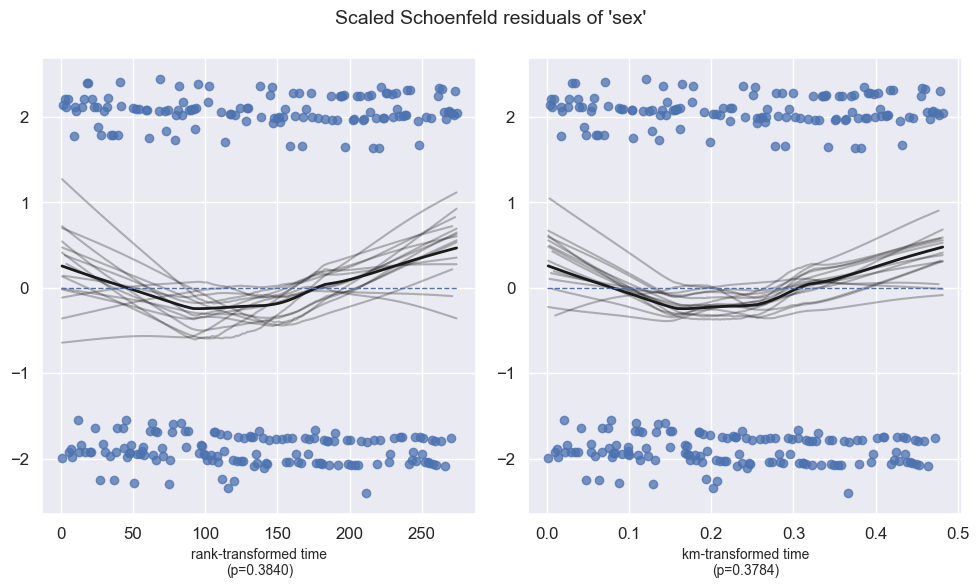

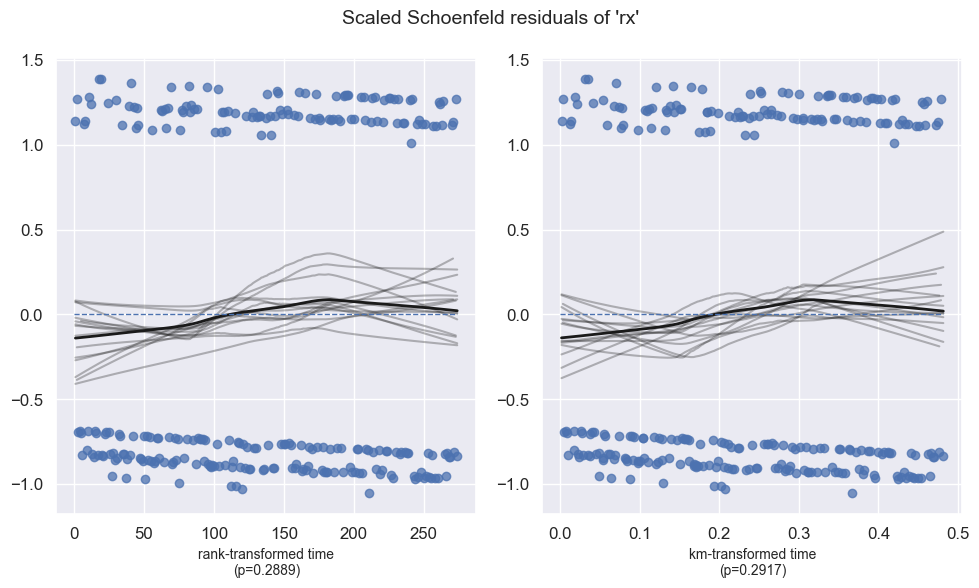

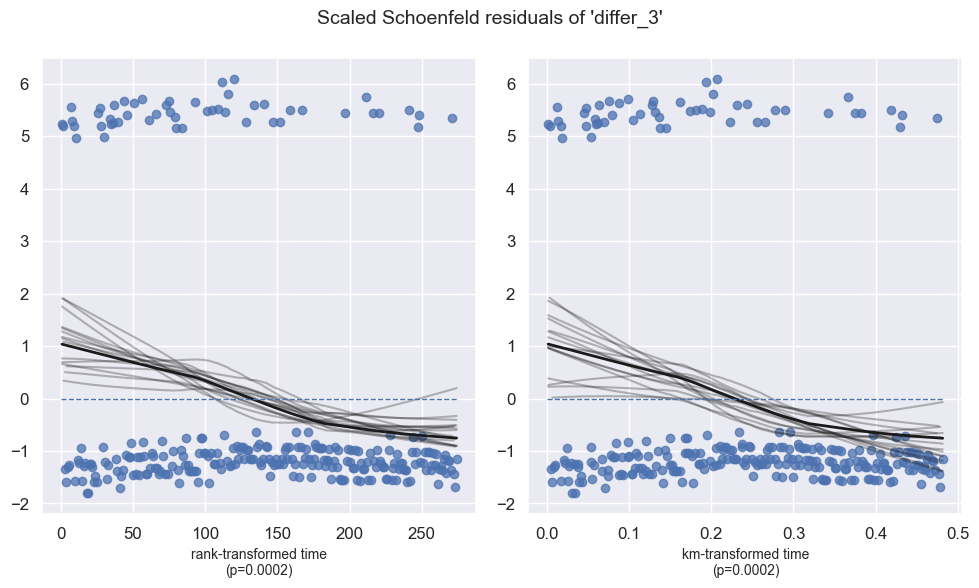

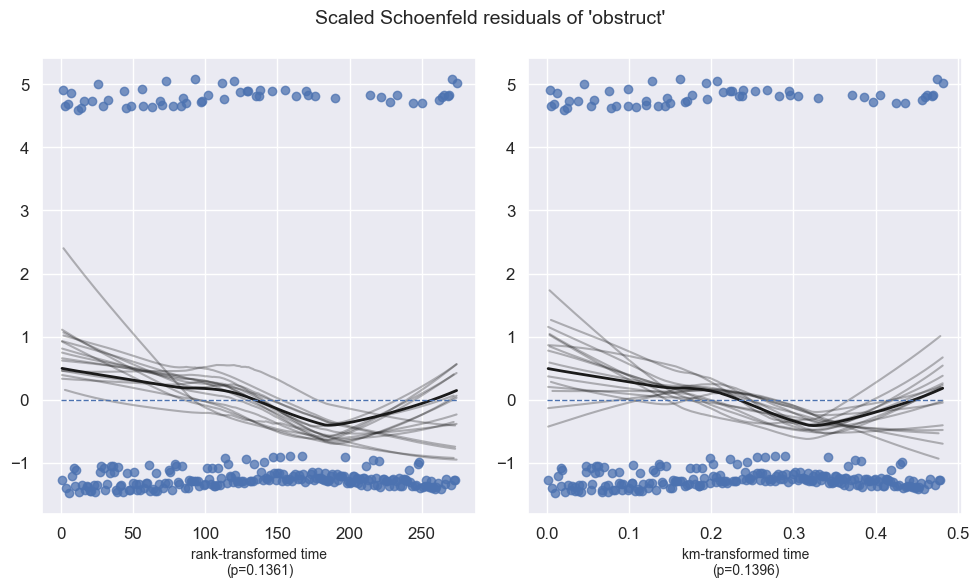

In [83]:
cph.check_assumptions(colon[['time', 'status', 'sex', 'rx', 'differ_3', 'obstruct']], p_value_threshold=0.05, show_plots= True)

Założenie proporcjonalnych hazardów nie jest spełnione dla zmiennej differ_3. Aby skorygować model proporcjonalnych hazardów tak, aby uwzględniał nieproporcjonalne bazowe funkcje hazardu dla zmiennej differ_3 możemy spróbować stratyfikacji. Stratyfikacja generalnie polega na podziale zmiennej na podgrupy i wyestymowaniu osobnej bazowej funkcji hazardu dla każdej z nich. Zmienna differ_3 oczywiście ma tylko 2 grupy, także dla tych 2 grup estymujemy bazową funkcję hazardu.  

In [84]:
print(colon[['differ_3']].info())
print(colon['differ_3'].unique())
print(colon['differ_3'].isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 583 entries, 0 to 887
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   differ_3  583 non-null    bool 
dtypes: bool(1)
memory usage: 21.3 KB
None
[ True False]
0


Musimy odpowiedno przygotować zmienną, tak aby poprawnie przekazać ją do funckji jako strat

In [85]:
colon_strat = colon.copy()
colon_strat['differ_3'] = colon_strat['differ_3'].astype(str)

In [86]:
cph = lfl.CoxPHFitter()

cph.fit(
    colon_strat[['time', 'status', 'sex', 'rx', 'obstruct', 'differ_3']], 
    duration_col='time', 
    event_col='status', 
    strata=['differ_3']
)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 583 total observations, 309 right-censored observations>
             duration col = 'time'
                event col = 'status'
                   strata = differ_3
      baseline estimation = breslow
   number of observations = 583
number of events observed = 274
   partial log-likelihood = -1516.93
         time fit was run = 2025-06-08 09:59:44 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
sex       -0.25      0.78      0.12           -0.49           -0.01                0.61                0.99
rx        -0.25      0.78      0.06           -0.38           -0.13                0.69                0.87
obstruct   0.26      1.30      0.15           -0.03            0.55                0.97                1.74

           cmp to     z      p  -log2(p)
covariate                               
sex          0.00 -2.05   0.04      4.63
rx           0.00 -4.14 <0.005     14.79
obstruct     0.00  1.75   0.08      3.63
---
Concordance = 0.60
Partial AIC = 3039.86
log-likelihood ratio test = 23.65 on 3 df
-log2(p) of ll-ratio test = 15.05

szacowania parametrów są podobne jak w poprzednich modelach Coxa. Uwagę powinien zwrócić brak parametru dla zmiennej differ_3. Jest to spodziewane, mamy wyestymowane 2 nieproporcjonalne bazowe funkcje hazardu, więc nie mamy współczynnika określającego proporcję hazardów. 
Natomiast najbardziej interesuje nas, czy założenia modelu są spełnione. Sprawdzamy to za pomocą check_assumptions w pakiecie lifelines.


In [88]:
cph.check_assumptions(colon_strat[['time', 'status', 'sex', 'rx', 'differ_3', 'obstruct']], p_value_threshold=0.05, show_plots= False)

Proportional hazard assumption looks okay.


[]

Dodajemy również model ze zmienną differ_3 zależną liniowo od czasu. Żeby to zrobić trzeba najpierw odpowiednio przygotować dane

In [95]:
colon_tv = colon.copy()
colon_tv['differ_3*time'] = colon_tv['differ_3']*colon_tv['time']

In [96]:
from lifelines.utils import to_episodic_format

colon_tv = to_episodic_format(colon[['time', 'status', 'rx', 'sex', 'obstruct', 'differ_3']], duration_col='time', event_col='status', time_gaps=100.)
colon_tv.head(25)

,stop,start,status,differ_3,id,obstruct,rx,sex
0,8.0,0.0,1,True,0,0,3,0
1,9.0,0.0,1,True,1,1,3,1
2,19.0,0.0,1,False,2,1,1,1
3,23.0,0.0,0,True,4,0,3,0
4,24.0,0.0,0,True,5,1,1,1
5,28.0,0.0,1,False,6,0,1,1
6,35.0,0.0,1,False,7,1,1,1
7,38.0,0.0,1,False,9,0,1,0
8,40.0,0.0,1,True,10,1,3,0
9,45.0,0.0,0,False,13,1,3,1


In [97]:
colon_tv['differ_3*time'] = colon_tv['differ_3']*colon_tv['stop']

In [98]:
colon_tv['stop']

0          8.0
1          9.0
2         19.0
3         23.0
4         24.0
         ...  
8907    3000.0
8908    3100.0
8909    3200.0
8910    3300.0
8911    3329.0
Name: stop, Length: 8912, dtype: float64

In [99]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()

ctv.fit(colon_tv,
        id_col='id',
        event_col='status',
        start_col='start',
        stop_col='stop')

<lifelines.CoxTimeVaryingFitter: fitted with 8912 periods, 583 subjects, 274 events>

In [100]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 8912 periods, 583 subjects, 274 events>
         event col = 'status'
number of subjects = 583
 number of periods = 8912
  number of events = 274
partial log-likelihood = -1636.33
  time fit was run = 2025-06-08 10:00:57 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
differ_3       1.35      3.85      0.27            0.81            1.89                2.25                6.59
obstruct       0.26      1.30      0.15           -0.03            0.55                0.97                1.74
rx            -0.25      0.78      0.06           -0.37           -0.13                0.69                0.88
sex           -0.25      0.78      0.12           -0.49           -0.01                0.61                0.99
differ_3*time -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

               cmp to     z      p  -log2(p)
covariate                                   
differ_3         0.00  4.93 <0.005     20.19
obstruct         0.00  1.74   0.08      3.62
rx               0.00 -4.13 <0.005     14.73
sex              0.00 -2.05   0.04      4.63
differ_3*time    0.00 -3.39 <0.005     10.49
---
Partial AIC = 3282.65
log-likelihood ratio test = 47.12 on 5 df
-log2(p) of ll-ratio test = 27.47